In [1]:
from PIL import Image, ImageDraw, ImageFont
import torch as th
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from functools import lru_cache
import requests
from io import BytesIO

import requests
from PIL import Image
from io import BytesIO
from functools import lru_cache

# sdxl_vae.config.scaling_factor
challenge_images = [
    "https://i.redd.it/rw7g1xmvx1wc1.jpeg",  # cosplayers
    "https://www.takewalks.com/blog/wp-content/uploads/2023/06/walks_sf_day_01.jpg",  # chinatown
    "https://i.redd.it/ktzyxj3prjz81.jpg",  # flowers, painful colors
    "https://static01.nyt.com/images/2018/10/05/us/05sfbuildings/merlin_136702875_6d0ee402-e952-4402-b5b3-d2a2d8668147-superJumbo.jpg",  # lots of buildings
    "https://i.redd.it/zm4px3hvggj51.jpg",  # "", # magazines, brutal text
]

challange_images_name = {
    "cosplayers": "https://i.redd.it/rw7g1xmvx1wc1.jpeg",
    "chinatown": "https://www.takewalks.com/blog/wp-content/uploads/2023/06/walks_sf_day_01.jpg",
    "flowers": "https://i.redd.it/ktzyxj3prjz81.jpg",
    "buildings": "https://static01.nyt.com/images/2018/10/05/us/05sfbuildings/merlin_136702875_6d0ee402-e952-4402-b5b3-d2a2d8668147-superJumbo.jpg",
    "magazines": "https://i.redd.it/zm4px3hvggj51.jpg",
}
import os

# too easy
# "https://preview.redd.it/itap-of-a-abandoned-house-v0-ydm9ym48uofb1.jpg?auto=webp&s=42917a397f42ba6f7b5fc7ad041ebb910d12a8f1",
# "https://www.jocooks.com/wp-content/uploads/2023/07/berry-tart-1-10.jpg",


def load_image_from_url(name):
    url = challange_images_name[name]
    try:
        # check if the image exists in contents.
        if os.path.exists(f"contents/{name}.jpg"):
            image = Image.open(f"contents/{name}.jpg")
            print(f"Loaded {name} from contents.")
        else:
            # Send a GET request to the URL
            response = requests.get(url)
            response.raise_for_status()  # Raise an exception for bad status codes

            # Create a Pillow Image object from the response content
            image = Image.open(BytesIO(response.content))
            # also save the image to contents.
            image.save(f"contents/{name}.jpg")

        image = TF.center_crop(TF.resize(image, 256, TF.InterpolationMode.BICUBIC), 256)
        return image

    except requests.RequestException as e:
        print(f"Error fetching the image: {e}")
        raise
    except Image.UnidentifiedImageError:
        print("The URL does not point to a valid image file.")
        raise


# for im_url in challenge_images:
#     # print(im_url)
#     display(load_image_from_url(im_url))
challenge_tensors = [
    TF.to_tensor(load_image_from_url(name)) for name in challange_images_name
]

Loaded cosplayers from contents.
Loaded chinatown from contents.
Loaded flowers from contents.
Loaded buildings from contents.
Loaded magazines from contents.


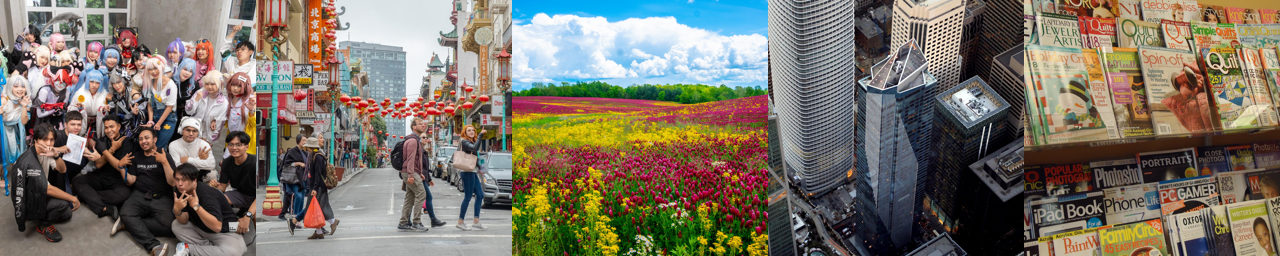

In [2]:
display(TF.to_pil_image(th.cat(challenge_tensors, -1)))

In [3]:
import torch
from diffusers import AutoencoderKL

flux_vae = (
    AutoencoderKL.from_pretrained(
        "black-forest-labs/FLUX.1-schnell", torch_dtype=torch.float16, subfolder="vae"
    )
    .to("cuda")
    .requires_grad_(False)
)

/home/ubuntu/py39cuda/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
from ae import VAE
import torch
from PIL import Image
import torch.nn as nn
import torch as th

vae = (
    VAE(
        resolution=256,
        in_channels=3,
        ch=128,
        out_ch=3,
        ch_mult=[1, 2, 4, 4],
        num_res_blocks=2,
        z_channels=16,
        use_attn=False,
        decoder_also_perform_hr=True,
    )
    .cuda()
    .bfloat16()
)
# path = "/home/ubuntu/auravasa/ckpt/stage_4_msepool-cont-512-1.0-1.0-batch-gradnorm_make_deterministic/vae_epoch_4_step_80001.pt"
path = "/home/ubuntu/auravasa/ckpt/stage_1_perceppool_128_hdr_nogan/vae_epoch_3_step_78501.pt"
sd = th.load(path)
sd = {k.replace("module.", "").replace("_orig_mod.", ""): v for k, v in sd.items()}
vae.load_state_dict(sd, strict=True)


class VAEWrapper(nn.Module):
    def __init__(self, vae):
        super().__init__()
        self.vae = vae

    @th.no_grad()
    def encode(self, x):
        # assert abs(x.mean()) < 0.1, f"x might not be zero-centered? mean is {x.mean()}"
        return self.vae.encoder(x.to(th.bfloat16)).clamp(-8, 8).to(x.dtype)

    @th.no_grad()
    def decode(self, x):
        x = x.to(th.bfloat16)
        dacc = self.vae.decoder(x.to(th.bfloat16)).to(x.dtype)
        # downsize by 2
        dacc = F.interpolate(dacc, scale_factor=0.5, mode="bilinear")
        # for do_flip_h in [0, 1]:
        #     for do_flip_v in [0, 1]:
        #         xr = x.clone()
        #         if do_flip_h:
        #             xr = torch.flip(xr, [-1])
        #             xr[:, -4:-2] = -xr[:, -4:-2]
        #         if do_flip_v:
        #             xr = torch.flip(xr, [-2])
        #             xr[:, -2:] = -xr[:, -2:]
        #         out = self.vae.decoder(xr.to(th.bfloat16)).to(x.dtype)

        #         if do_flip_h:
        #             out = torch.flip(out, [-1])

        #         if do_flip_v:
        #             out = torch.flip(out, [-2])
        #         dacc += out

        return dacc
        # return dacc


aura_equi_vae = VAEWrapper(vae)

/tmp/ipykernel_2863597/1287491015.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = th.load(path)


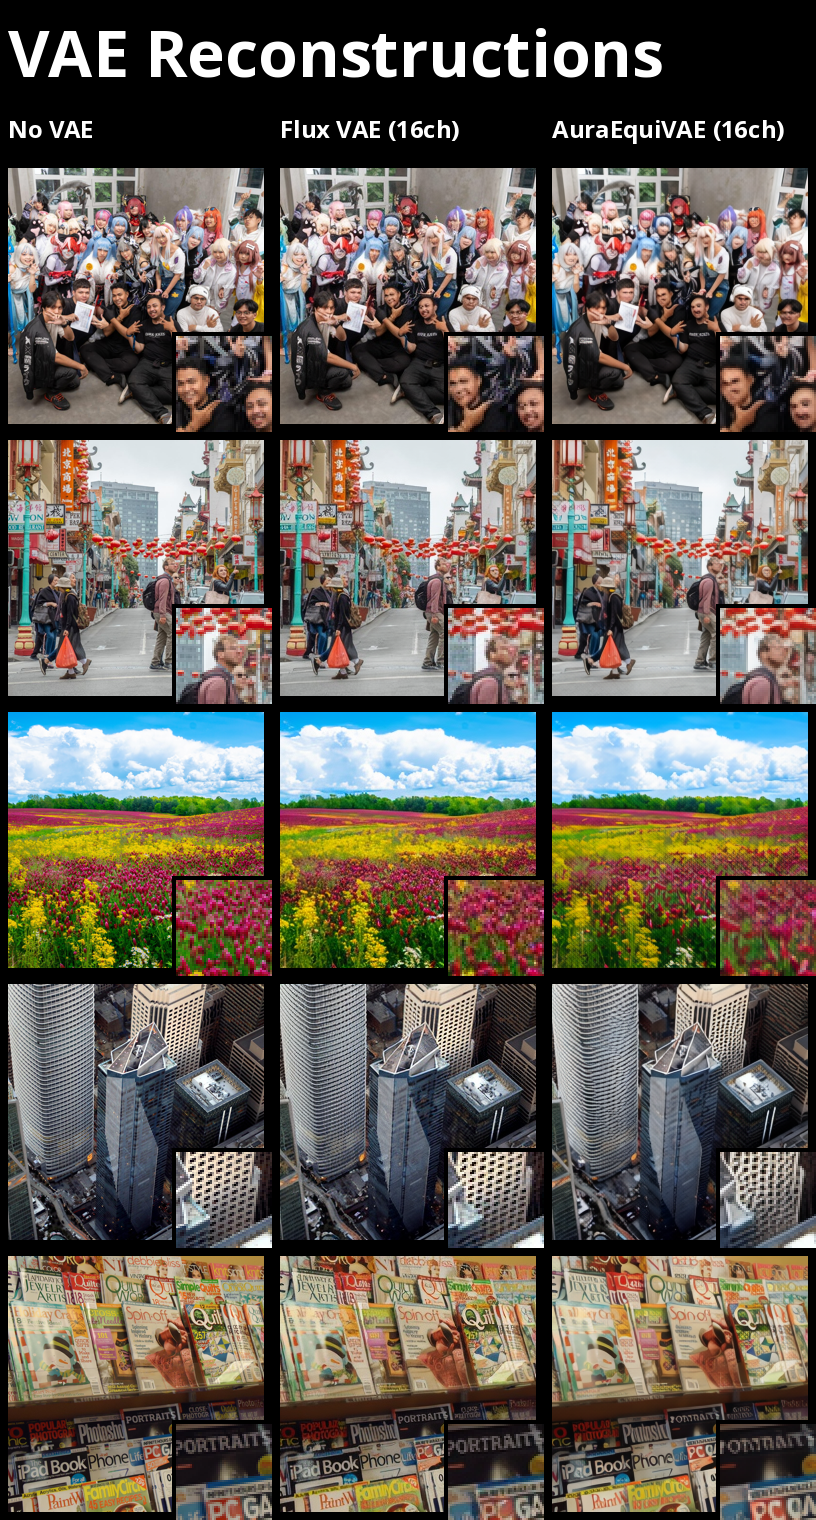

None

In [10]:
@lru_cache
def get_font(bold=True, size=32):
    if bold:
        font_url = "https://github.com/openmaptiles/fonts/raw/master/noto-sans/NotoSans-Bold.ttf"
    else:
        font_url = "https://github.com/openmaptiles/fonts/raw/master/noto-sans/NotoSans-Regular.ttf"
    font_response = requests.get(font_url)
    font_data = BytesIO(font_response.content)
    font = ImageFont.truetype(font_data, size)
    return font


def render_title_image(label, width, height, py=0, px=0):
    im_out = Image.new("RGB", (width, height))
    draw = ImageDraw.Draw(im_out)
    # draw.text((px, 8), label + " Latent Modification Chart", font=get_font(bold=True, size=64), fill=(255, 255, 255))
    draw.text((px, py), label, font=get_font(bold=True, size=24), fill=(255, 255, 255))
    # draw.text((px, 8 + 96), f"Image-space effects of various modifications to the {label} latents.", font=get_font(bold=True), fill=(127, 127, 127))
    return TF.to_tensor(im_out)


def render_column(label, ims, pad=8, inset_size=48, inset_scale=2, inset_offsets=None):
    title = render_title_image(
        label, width=ims.shape[-1] + pad * 2, height=64, py=16, px=pad
    )

    iy = (ims.shape[-2] - inset_size) // 2
    ix = (ims.shape[-1] - inset_size) // 2
    inset = F.interpolate(
        th.stack(
            [
                im[:, oy + iy : oy + iy + inset_size, ox + ix : ox + ix + inset_size]
                for im, (oy, ox) in zip(ims, inset_offsets)
            ],
            0,
        ),
        scale_factor=inset_scale,
    )

    ims = F.pad(ims, (pad,) * 4)

    ims[:, :, -inset.shape[-2] - pad // 2 :, -inset.shape[-1] - pad // 2 :] *= 0
    ims[:, :, -inset.shape[-2] :, -inset.shape[-1] :] = inset
    # render inset
    return th.cat([title] + list(ims), -2)


def make_header_image(label, width=512, height=96, py=64, px=16):
    im_out = Image.new("RGB", (width, height))
    draw = ImageDraw.Draw(im_out)
    # draw.text((px, 8), label + " Latent Modification Chart", font=get_font(bold=True, size=64), fill=(255, 255, 255))
    draw.text((px, 8), label, font=get_font(bold=True, size=64), fill=(255, 255, 255))
    # draw.text((px, 8 + 96), f"Image-space effects of various modifications to the {label} latents.", font=get_font(bold=True), fill=(127, 127, 127))
    return TF.to_tensor(im_out)


@th.no_grad()
def render_challenge_image(vaes, image_list, inset_offsets, title):
    im = th.stack(image_list, 0)
    # out = [th.cat(tuple(im), -2)]
    out = [render_column("No VAE", im, inset_offsets=inset_offsets)]
    # TF.to_pil_image()
    for label, vae in vaes.items():
        if isinstance(vae, VAEWrapper):
            enc = vae.encode(im.half().mul(2).sub_(1).cuda())
            dec = vae.decode(enc).mul(0.5).add(0.5).clamp(0, 1).cpu()
        else:
            shift = vae.config.shift_factor or 0.0
            scale = vae.config.scaling_factor or 0.18215
            enc = vae.encode(im.half().mul(2).sub_(1).cuda())
            enc = (
                enc.latent_dist.sample() if hasattr(enc, "latent_dist") else enc.latents
            )
            enc = enc.sub_(shift).mul_(scale)
            dec = (
                vae.decode(enc.div_(scale).add_(shift))
                .sample.mul(0.5)
                .add(0.5)
                .clamp(0, 1)
                .cpu()
            )
        out.append(render_column(label, dec, inset_offsets=inset_offsets))
        # print(label)
        # out.append(th.cat(tuple(dec), -2))
    out = th.cat(out, -1)
    header = make_header_image(title, width=out.shape[-1], px=8)
    out = th.cat([header, out], -2)
    display(TF.to_pil_image(out))


# title = "16ch VAE Reconstructions"
# vaes = {
#     "SD3 VAE": sd3_vae,
#     "Aura VAE": aura_vae,
#     "Ostris VAE": ostris_vae,
# }
# title = "4ch VAE Reconstructions"
# vaes = {
#     # "SD3 VAE": sd3_vae,
#     # "Aura VAE": aura_vae,
#     # "Ostris VAE": ostris_vae,
#     "SD VAE": sd_vae,
#     "SD VAE (ft MSE)": sd_vae_mse,
#     "SD VAE (ft EMA)": sd_vae_ema,
#     "SDXL VAE": sdxl_vae,
# }
# title = "Tiny VAE Reconstructions"
# vaes = {
#     "TAESD": taesd,
#     "TAESDXL": taesdxl,
#     "TAESD3": taesd3,
# }
title = "VAE Reconstructions"
vaes = {
    # "SD VAE ft EMA (4ch)": sd_vae_ema,
    # "SDXL VAE (4ch)": sdxl_vae,
    # "SD3 VAE (16ch)": sd3_vae,
    "Flux VAE (16ch)": flux_vae,
    "AuraEquiVAE (16ch)": aura_equi_vae,
    # "Ostris VAE (16ch)": ostris_vae,
}


inset_offsets = [
    (0, 0),
    (0, 32),
    (48, 0),
    (-56, 48),
    (48, 16),
]

display(render_challenge_image(vaes, challenge_tensors, inset_offsets, title))